# RBM training - Dataset with $ T = \infty$

In order to investigate the RBM flow in an extreme situation, we train the machine in an dataset composed only byrandom states. This still does not satisfy the condition shown in the work [Scale-invariant Feature Extraction of Neural Network and Renormalization Group Flow](https://arxiv.org/abs/1801.07172): the RBM flow would go towards the critical value if the data training set has states with temperature values less and greater than the critical one.

It is crucial to note that, since the visible layer is always fed with an unidimensional vector (an array is transformed in a vector to be fed in the visible layer), the machine does not have any geometric information about the lattice in this case.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

from rbm import RBM
from MC_Ising2D import IsingMC

import torch
import torch.nn as nn
torch.manual_seed(12)

L = 100

#### Random configurations:

In [2]:
nstates = 1000

up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

up_down = torch.cat((up,down), 0)

data_set_high = up_down.reshape(1, up_down.shape[0])

for j in range(nstates - 1):
    
    data_set_high_ = up_down[torch.randperm(up_down.shape[0]) ]
    
    data_set_high = torch.cat( ( data_set_high, data_set_high_.reshape(1, data_set_high_.shape[0])), 0 )

#### Constructing training and test sets

Using `train_test_split` from [`sklearn`](http://scikit-learn.org/) it is easy to split the data into training and test sets.

In [4]:
train_data, test_data = train_test_split(np.array(data_set_high),
                                         test_size= 0.2,
                                         random_state= 12)

In [5]:
training_set = torch.Tensor(train_data)
test_set = torch.Tensor(test_data)

training_set = training_set[torch.randperm(training_set.size()[0])]

#### Training the model

Our code implementing a Restricted Boltzmann Machine is written a python class called `RBM` which is imported from `rbm.py`.

For simplification, the units have no bias and the RBM stochasticity parameter, represented below by $T$ is set to unity, as usual in most practical applications. Note that we set `use_cuda=True`, which makes use of [CUDA tensor types](https://pytorch.org/docs/stable/cuda.html), implementing GPU computation. If a GPU is not available, one should just set `use_cuda=False`.

In [6]:
Nv = training_set.shape[1]
Nh = training_set.shape[1]

lr = 0.001
k_learning = 1
batch_size = 100
nb_epoch = 1000
k_sampling = 1

rbm = RBM(num_visible= Nv, 
          num_hidden= Nh, 
          bias= False,
          T= 1.0,
          use_cuda= True)
    
rbm.learn(training_set= training_set,
          test_set = test_set,
          lr= lr, 
          nb_epoch= nb_epoch, 
          batch_size= batch_size,
          k_learning= k_learning,
          k_sampling= k_sampling,
          verbose= 1)

RBM --- Nv= 10000, Nh= 10000, lr= 1.0E-03, k= 1, Bsize= 100, Epochs= 1000, USE_CUDA= True, verbose= 1
Starting training
Ep 1, Rec er: 0.301479 (train), 0.274352 (test), Pseud_Lik: -7260.848870, Time: 16.754849, 
Ep 2, Rec er: 0.273018 (train), 0.275451 (test), Pseud_Lik: -6560.936036, Time: 10.421162, 
Ep 3, Rec er: 0.276327 (train), 0.280537 (test), Pseud_Lik: -7048.409230, Time: 11.342332, 
Ep 4, Rec er: 0.281338 (train), 0.287343 (test), Pseud_Lik: -6375.926961, Time: 10.823742, 
Ep 5, Rec er: 0.287207 (train), 0.293576 (test), Pseud_Lik: -6627.489896, Time: 12.273380, 
Ep 6, Rec er: 0.293374 (train), 0.299841 (test), Pseud_Lik: -7417.092425, Time: 12.657241, 
Ep 7, Rec er: 0.299383 (train), 0.306514 (test), Pseud_Lik: -7059.256587, Time: 12.593630, 
Ep 8, Rec er: 0.305262 (train), 0.313127 (test), Pseud_Lik: -6152.893304, Time: 11.459582, 
Ep 9, Rec er: 0.311302 (train), 0.319548 (test), Pseud_Lik: -6663.091806, Time: 12.514888, 
Ep 10, Rec er: 0.317383 (train), 0.324968 (test), Ps

KeyboardInterrupt: 

#### Saving the trained model

In [7]:
nb_epoch = rbm.num_train_epochs()

name = 'RBM_model_inf_T_nv%d_nh%d_lr%.1E_k%d_bsize%d_nepochs%d' % (Nv,
                                                                   Nh,
                                                                   lr,
                                                                   k_learning,
                                                                   batch_size,
                                                                   nb_epoch)

PATH = 'RBM_trained_models/'+ name + '.pt'

torch.save(rbm, PATH)

### Weights distribution

In [8]:
W, v, h = rbm.parameters()

del v
del h
torch.cuda.empty_cache()

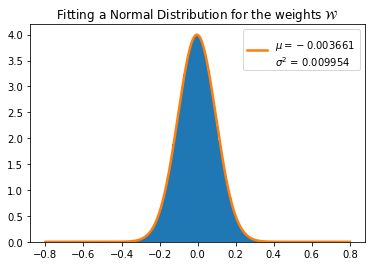

In [9]:
W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1]))

# Plot normalized histogram 
plt.hist(W_, bins= 100, density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])  
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution
muW_, sigmaW_ = stats.norm.fit(W_) 

plot_pdf = stats.norm.pdf(domain, muW_, sigmaW_) # Fitting the PDF in the interval


plt.plot(domain, plot_pdf, linewidth= 2.5,
         label= '$\mu= %f$ \n$\sigma^2$ = %f' % (muW_, sigmaW_**2 ))

plt.title('Fitting a Normal Distribution for the weights ${\cal W}$')
plt.legend()
plt.show()

In [10]:
del W
torch.cuda.empty_cache()